## Scan of ssd (cut-out)  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tomo2mesh.misc import viewer
raw_fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/Tekawade_SSD_050.h5'
rec_fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/reconstructed_gray'
# seg_fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/reconstructed_bumps'
pg_dict = None #{"alpha" : 0.00005, "energy" : 50.0, "detector_dist_cm" : 15.0, "pixel_size_um" : 0.67, "pg_pad" : 10}

## Find Center  
Center finding can be done using MSE (uses cupy) or NCC (uses skimage match_template) metrics  

In [2]:
from tomo2mesh.misc import find_center

In [3]:
pair = find_center.read_opposing_pairs(raw_fpath)
search_width = 20 # 20 pixels on left and 20 on right of guessed center
_, nz, n = pair.shape
center_guess = n//2
search_range = (center_guess - search_width, center_guess + search_width)
center = find_center.estimate_center(pair, search_range, roi_width = 0.8, metric = "MSE", roi_height = (0,1))
print(f"found center at {center}")

found center at 1616


## Read and reconstruct raw data from dxchange file  
Raw data can be read as a set of projections, theta, dark, flat. A helper function is provided if data is in dxchange format. Then, you may reconstruct a slice or a full volume. A viewer module is provided for easily viewing reconstructed and segmented slices.  

In [4]:
from tomo2mesh.misc.rw_dxchange import read_raw_data_any

In [5]:
projs, theta, dark, flat = read_raw_data_any(raw_fpath)
ntheta, nz, n = projs.shape
projs = projs[:, :-int(nz%128), :-int(n%128)].copy()
flat = flat[:-int(nz%128), :-int(n%128)].copy()
dark = dark[:-int(nz%128), :-int(n%128)].copy()
print(f"shape of projection data ntheta, nz, n : {projs.shape}")

shape of projection data ntheta, nz, n : (3201, 2304, 3200)


In [6]:
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all

In [7]:
img = recon_slice(projs, theta, center, dark, flat, 0.5, pg_dict = pg_dict)

data shape: (ntheta, nz, n) (3201, 1, 3200)


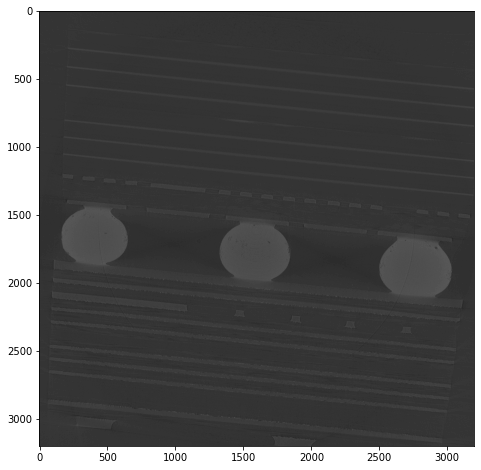

In [8]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(img, cmap = 'gray')

In [9]:
vol = recon_all(projs, theta, center, 32, dark, flat, pg_dict = pg_dict, outlier_removal = True)

100%|███████████████████████████████████████████| 72/72 [14:35<00:00, 12.17s/it]


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

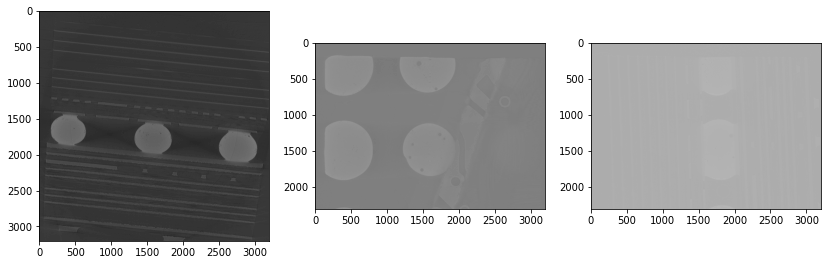

In [10]:
fig, ax = plt.subplots(1,3, figsize = (14,8))
viewer.view_midplanes(vol = vol, ax = ax)

## Plot image slices  

In [11]:
from tomo2mesh.misc.voxel_processing import modified_autocontrast
pixel_size_um = 0.67 # pg_dict["pixel_size_um"]

In [12]:
imx = viewer.get_orthoplanes(vol = vol, idxs = None) # provide a list of three indices (z, y, x) for custom slices  

<AxesSubplot:>

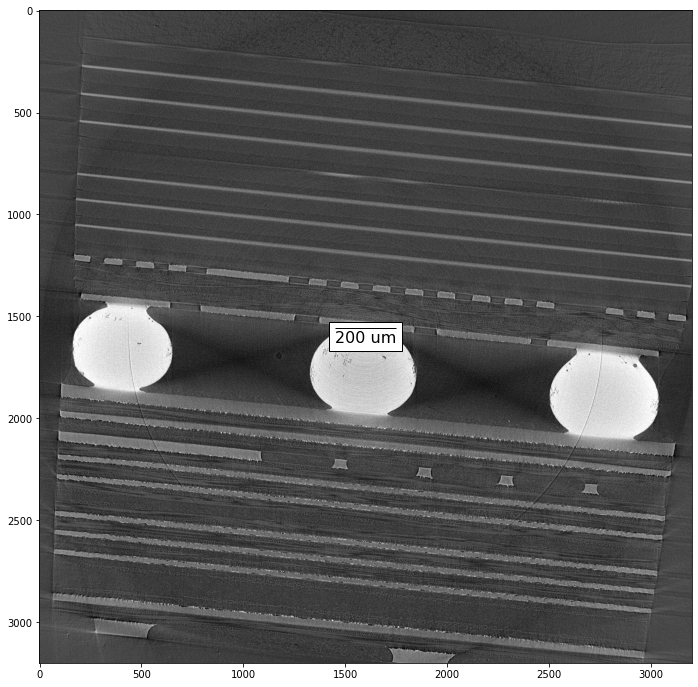

In [13]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
h = modified_autocontrast(imx[1])
ax.imshow(np.clip(imx[0], *h), cmap = 'gray')
viewer.add_scalebar(ax, 200, pixel_size_um, units = 'um', loc="center")

<AxesSubplot:>

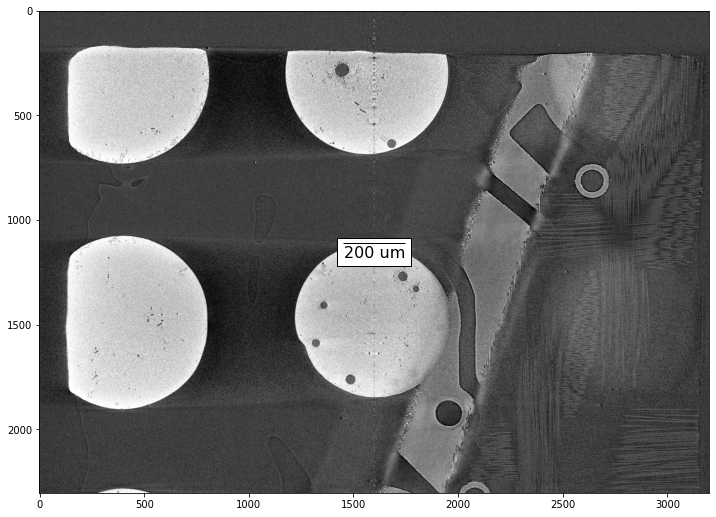

In [14]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
h = modified_autocontrast(imx[1])
ax.imshow(np.clip(imx[1], *h), cmap = 'gray')
viewer.add_scalebar(ax, 200, pixel_size_um, units = 'um', loc="center")

<AxesSubplot:>

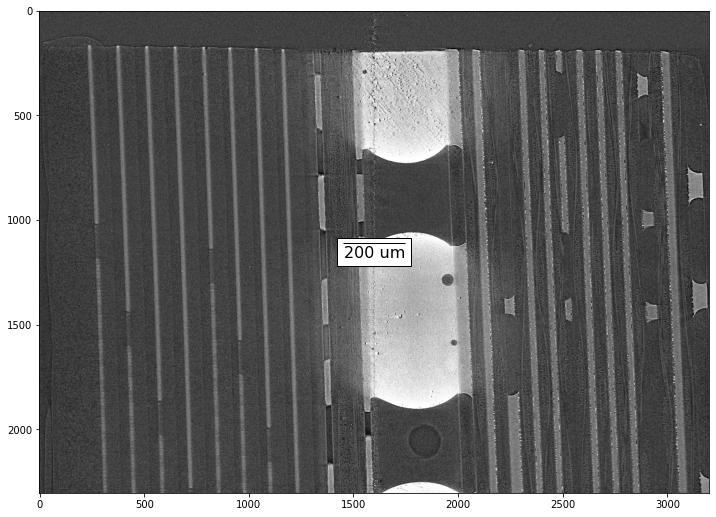

In [15]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
h = modified_autocontrast(imx[2])
ax.imshow(np.clip(imx[2], *h), cmap = 'gray')
viewer.add_scalebar(ax, 200, pixel_size_um, units = 'um', loc="center")

## Saving data  
Saving and reading reconstructed / segmented 3D volumes can be done using DataFile class. To save disk memory, we can normalize and convert reconstructed volume into 16-bit. Normalize function provided uses cupy for fast pixel operations. Conversion of grayscale to 16-bit will result in lossy compression.    

In [16]:
from tomo2mesh import DataFile
from tomo2mesh.misc.voxel_processing import normalize_volume_gpu
vol = (normalize_volume_gpu(vol)*(2**16-1)).astype(np.uint16)

In [17]:
dfile = DataFile(rec_fpath, tiff = True, d_shape = vol.shape, d_type = vol.dtype)
dfile.create_new(overwrite=True)
dfile.write_full(vol)
dfile.show_stats()

Removed old contents in tiff folder reconstructed_gray

Dataset shape: (2304, 3200, 3200)
Dataset size: 47.19 GB
Slice size along 0: 20.48 MB
Slice size along 1: 14.75 MB
Slice size along 2: 14.75 MB
